In [1]:
import mdtraj as md
import pyemma as pm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Optional, Union, Tuple
from pathlib import Path
import pickle
import seaborn as sns
import os
from itertools import product
import string
import pickle

import matplotlib as mpl
from matplotlib import colors

from msmtools.estimation import transition_matrix as _transition_matrix
from msmtools.analysis import timescales as _timescales

import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Dihedral, Ramachandran

/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mpl.rcParams['savefig.bbox'] = 'tight'
sns.set_style("white")
sns.set_style({'font.family':'sans-serif', 'font.serif':'Arial'})

In [3]:
def featurizer(hp_dict: Dict, traj_paths: List[str], top_path: str) -> List[np.ndarray]:
    if hp_dict['feature__value'] == 'dihedrals':
        assert hp_dict['dihedrals__which'] == 'all'
        def f(traj: md.Trajectory, **kwargs) -> np.ndarray:
            _, phi = md.compute_phi(traj)
            _, psi = md.compute_psi(traj)
            _, chi1 = md.compute_chi1(traj)
            _, chi2 = md.compute_chi2(traj)
            _, chi3 = md.compute_chi3(traj)
            _, chi4 = md.compute_chi4(traj)
            _, chi5 = md.compute_chi5(traj)
            ftraj = np.concatenate([phi, psi, chi1, chi2, chi3, chi4, chi5], axis=1)
            ftraj = np.concatenate([np.cos(ftraj), np.sin(ftraj)], axis=1)
            return ftraj

    elif hp_dict['feature__value'] == 'distances':
        def f(traj: md.Trajectory, **kwargs):
            scheme = kwargs['distances__scheme']
            transform = kwargs['distances__transform']
            centre = kwargs['distances__centre']
            steepness = kwargs['distances__steepness']
            ftraj, _ = md.compute_contacts(traj, scheme=scheme)
            if transform=='logistic':
                ftraj = 1.0/(1+np.exp(-steepness*(ftraj - centre)))
            return ftraj
    else:
        raise ValueError
    ftrajs = []
    for traj_path in traj_paths:
        traj = md.load(traj_path, top=top_path)
        ftrajs.append(f(traj, **hp_dict))
    return ftrajs


def tica(hp_dict: Dict[str, Union[float, int, str]], ftrajs: List[np.ndarray]) -> List[np.ndarray]:
    lag = hp_dict['tica__lag']
    stride = hp_dict['tica__stride']
    dim = hp_dict['tica__dim']
    tica = pm.coordinates.tica(ftrajs, lag=lag, dim=dim, kinetic_map=True)
    ttrajs = tica.get_output()
    return ttrajs, tica

def kmeans(hp_dict: Dict, ttrajs: List[np.ndarray], seed: int) -> List[np.ndarray]:
    k = hp_dict['cluster__k']
    max_iter = hp_dict['cluster__max_iter']
    stride = hp_dict['cluster__stride']
    kmeans = pm.coordinates.cluster_kmeans(ttrajs, k=k, max_iter=max_iter, stride=stride, fixed_seed=seed, n_jobs=1)
    dtrajs = kmeans.dtrajs
    return dtrajs, kmeans


def its(dtrajs: List[np.ndarray], lags: List[int], nits: int) -> np.ndarray:
    its_obj = pm.msm.timescales_msm(dtrajs=dtrajs, lags=lags, nits=nits)
    return its_obj.timescales


def score(dtrajs: List[np.ndarray], lags: List[int], nits: int) -> np.ndarray:
    all_vs = []
    for lag in lags: 
        m = pm.msm.estimate_markov_model(dtrajs, lag=lag)
        vs = np.array([m.score(dtrajs, score_k=k) for k in range(2, nits+2)])
        vs = vs.reshape(1, -1)
        all_vs.append(vs)
    all_vs = np.concatenate(all_vs, axis=0)
    return all_vs
        


def bootstrap(ftrajs: List[np.ndarray], rng: np.random.Generator) -> List[np.ndarray]:
    probs = np.array([x.shape[0] for x in ftrajs])
    probs = probs/np.sum(probs)
    ix = np.arange(len(ftrajs))
    new_ix = rng.choice(ix,size=len(ftrajs), p=probs, replace=True)
    return [ftrajs[i] for i in new_ix], new_ix



def summarise(df):
    df_summary = df.groupby(['hp_ix', 'lag', 'process']).agg(median=(0, lambda x: np.quantile(x, 0.5)),
                                                                   lb=(0, lambda x: np.quantile(x, 0.025)),
                                                                   ub=(0, lambda x: np.quantile(x, 0.975)), 
                                                                   count =(0, lambda x: x.shape[0]-x.isna().sum()))
    return df_summary


def samples_to_summary(samples: np.ndarray, lags: List[int],  hp_ix: int)-> pd.DataFrame: 
    """
    samples=np.ndarray[lagtime, process, bs_sample]
    """
    df = pd.concat({(hp_ix, lags[i], j+2): pd.DataFrame(samples[i, j, :]) for i in range(samples.shape[0]) for j in range(samples.shape[1])})
    df.index.rename(('hp_ix', 'lag', 'process', 'bs_ix'), inplace=True)
    df_summary = summarise(df)
    return df_summary

In [4]:
# MSM parameters

protein = 'CLN'
seed = 49587
rng = np.random.default_rng(seed)
lags = list(range(1, 102, 10))
lags_test = [1, 5, 10, 20, 50, 100, 200, 500, 1000]
n_bootstraps = 100
nits= 25
lag = 31
    # 41
hp_ix = 218
hp_ixs = [52, 218]
    # hp_ixs = [24, 95, 227]
n_ts = 10

# PCCA+ parameters
n_sets = 2
core_membership_cutoff = 0.9

# Input path 
summary_path = r'../CLN/maximize_t2.h5'
    # r'../BBA/t2.h5'
top_path = '../../../chignolin/protein.pdb'
    # '../../../1fme/protein.pdb'
traj_paths = list(Path(r'../../../chignolin').rglob(f'CLN025-0-protein-*.xtc'))
    # list(Path(r'../../../1fme').rglob(f'1FME-*.xtc'))
traj_paths = [str(x) for x in traj_paths]
traj_paths.sort()

In [5]:
hps = pd.read_hdf(summary_path)

# Rename hyperparameters
hps.rename(columns=dict(number='hp_ix', 
                        params_centre='distances__centre', 
                        params_feature='feature__value', 
                        params_n_clusters='cluster__k', 
                        params_scheme='distances__scheme', 
                        params_steepness='distances__steepness', 
                        params_tica_dim='tica__dim', 
                        params_tica_lag='tica__lag', 
                        params_transform='distances__transform'), inplace=True)
hps['tica__stride'] = 1
hps['cluster__stride'] = 1
hps['dihedrals__which'] = 'all'
hps['cluster__max_iter'] = 1000
hps['feature'] = hps.apply(lambda x: f"{x['feature__value']}" if x['feature__value'] =='dihedrals' else f"{x['distances__transform']}-{x['feature__value']}", axis=1)

# Rename features
def f(x):
    for short, long in short_names.items(): 
        x = x.replace(short, long)
    return x
short_names = {'dihedrals': 'dihed.','logistic-distances': 'logit(dist.)', 'linear-distances': 
              'dist.'}
hps['feature'] = hps['feature'].apply(f)

hps.query(f'hp_ix=={hp_ix}')

,hp_ix,value,datetime_start,datetime_complete,duration,distances__centre,feature__value,cluster__k,distances__scheme,distances__steepness,tica__dim,tica__lag,distances__transform,state,tica__stride,cluster__stride,dihedrals__which,cluster__max_iter,feature
218,218,388.192654,2022-12-14 18:53:54.379169,2022-12-14 18:55:59.432164,0 days 00:02:05.052995,NaN,distances,469,ca,NaN,15,3,linear,COMPLETE,1,1,all,1000,dist.


---
### Compute BS MSM --- Figure 2

In [6]:
# Output path 
hps.set_index(['hp_ix'], inplace=True)
base_dir = Path(f"{protein}/hp{hp_ix}_{hps.loc[hp_ix,:]['feature']}")
fig_dir = Path.joinpath(base_dir, Path(f"figures"))
fig_dir.mkdir(parents=True, exist_ok=True)

In [7]:
try:
    with open(fig_dir.joinpath(f'{n_bootstraps}_bs'), 'rb') as f:
        data = pickle.load(f)
        ts_samples = data['ts_samples']
        gap_samples = data['gap_samples']
    with open(fig_dir.joinpath('mfpts_summary'), 'rb') as f:
        data = pickle.load(f)
        lags_test = data['lags_test']
        mfpt_fold = data['mfpts_fold']
        mfpt_unfold = data['mfpts_unfold']
except:
    print('Compute bootstraps and mfpts first!')

Compute bootstraps and mfpts first!


In [8]:
ftrajs_all = featurizer(hps.loc[hp_ix,:].to_dict(), traj_paths, top_path)

# Bootstrap results to get timescales and gaps
ts_samples = []
gap_samples = []

for i in range(n_bootstraps):
    ftrajs, ftrajs_ix = bootstrap(ftrajs_all, rng)
    assert len(ftrajs) == len(ftrajs_all)
    
    ttrajs, tica_mod = tica(hps.loc[hp_ix, :].to_dict(), ftrajs)
    dtrajs, kmeans_mod = kmeans(hps.loc[hp_ix, :].to_dict(), ttrajs, seed)
    
    if n_bootstraps>1:
        out_dir = Path.joinpath(base_dir, Path(f'bs_{i}'))
    else:
        out_dir = Path.joinpath(base_dir, Path(f'dtrajs'))
        
    out_dir.mkdir(parents=True, exist_ok=True)
    
    for j in range(len(traj_paths)): 
        traj_path = Path(traj_paths[j]).resolve()
        np.save(file=out_dir.joinpath(traj_path.with_suffix('.npy').name), arr=dtrajs[j])
        
    msm = pm.msm.estimate_markov_model(dtrajs, lag=lag)
    ts = msm.timescales(n_ts)
    
    ts_samples.append(ts[:-1]/1000)
    gap_samples.append(ts[:-1]/ts[1:])
    
ts_samples = np.array(ts_samples)
gap_samples = np.array(gap_samples)

with open(fig_dir.joinpath(f'{n_bootstraps}_bs'), 'wb') as f:
    pickle.dump({'ts_samples':ts_samples, 'gap_samples':gap_samples}, f)

/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|███████████████| 54/54 [00:00<00:00, 1845.39it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%| | 0/469 [00:00<?, ?
initialize kmeans++ centers:  99%|▉| 466/469 [00:06<00
kmeans iterations:   0%| | 1/1000 [00:06<1:55:04,  6.9
kmeans iterations:   0%| | 2/1000 [00:07<53:31,  3.22s
kmeans iterations:   0%| | 3/1000 [00:08<33:44,  2.03s

kmeans iterations:   1%| | 7/1000 [00:10<14:29,  1.14i
kmeans iterations:   1%| | 8/1000 [00:11<13:16,  1.25i
kmeans iterations:   1%| | 9/1000 [00:11<12:26,  1.33i
kmeans iterations:   1%| | 10/1000 [00:12<11:59,  1.38
kmeans iterations:   1%| | 11/1000 [00:13<11:33,  1.43
kmeans iterations:   1%| | 12/1000 [00:13<11:08,  1.48
kmeans iterations:   1%| | 13/1000 [00:14<10:58,  1.50
kmeans iterations:   1%| | 14/1000 [00:15<10:50,  1.52
kmeans iterations:   2%| | 15/1000 [00:15<10:45,  1.53
kmeans iterations:   2%| | 16/1000 [00:16<10:41,  1.53
kmeans iterations:   2%| | 17/1000 [00:17<10:39,  1.54
kmeans iterations:   2%| | 18/1000 [00:17<10:27,  1.56
kmeans iterations:   2%| | 19/1000 [00:18<10:28,  1.56
kmeans iterations:   2%| | 20/1000 [00:18<10:30,  1.55
kmeans iterations:   2%| | 21/1000 [00:19<10:31,  1.55
kmeans iterations:   2%| | 22/1000 [00:20<10:30,  1.55
kmeans iterations:   2%| | 23/1000 [00:20<10:29,  1.55
kmeans iterations:   2%| | 24/1000 [00:21<10:27,  1.56
kmeans ite

kmeans iterations:   4%| | 37/1000 [00:28<09:34,  1.67
kmeans iterations:   4%| | 38/1000 [00:29<09:34,  1.67
kmeans iterations:   4%| | 39/1000 [00:29<09:34,  1.67
100%|███████████████| 469/469 [00:31<00:00, 15.07it/s]

100%|████████████████| 54/54 [00:00<00:00, 640.74it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|███████████████| 54/54 [00:00<00:00, 1735.85it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw

kmeans iterations:   1%| | 7/1000 [00:10<14:31,  1.14i
kmeans iterations:   1%| | 8/1000 [00:11<13:15,  1.25i
kmeans iterations:   1%| | 9/1000 [00:11<12:24,  1.33i
kmeans iterations:   1%| | 10/1000 [00:12<11:40,  1.41
kmeans iterations:   1%| | 11/1000 [00:13<11:15,  1.46
kmeans iterations:   1%| | 12/1000 [00:13<11:00,  1.49
kmeans iterations:   1%| | 13/1000 [00:14<10:50,  1.52
kmeans iterations:   1%| | 14/1000 [00:15<10:34,  1.56
kmeans iterations:   2%| | 15/1000 [00:15<10:33,  1.56
kmeans iterations:   2%| | 16/1000 [00:16<10:28,  1.57
kmeans iterations:   2%| | 17/1000 [00:16<10:38,  1.54
kmeans iterations:   2%| | 18/1000 [00:17<10:20,  1.58
kmeans iterations:   2%| | 19/1000 [00:18<10:21,  1.58
kmeans iterations:   2%| | 20/1000 [00:18<10:17,  1.59
initialize kmeans++ centers: 100%|█| 469/469 [00:20<00
kmeans iterations:   2%| | 22/1000 [00:20<10:17,  1.58
kmeans iterations:   2%| | 23/1000 [00:20<10:18,  1.58
kmeans iterations:   2%| | 24/1000 [00:21<10:13,  1.59
kmeans ite

kmeans iterations:   4%| | 37/1000 [00:29<10:03,  1.60
kmeans iterations:   4%| | 38/1000 [00:30<09:53,  1.62
kmeans iterations:   4%| | 39/1000 [00:30<10:05,  1.59
kmeans iterations:   4%| | 40/1000 [00:31<10:03,  1.59
kmeans iterations:   4%| | 41/1000 [00:32<10:07,  1.58
kmeans iterations:   4%| | 42/1000 [00:32<10:01,  1.59
kmeans iterations:   4%| | 43/1000 [00:33<10:06,  1.58
kmeans iterations:   4%| | 44/1000 [00:33<10:00,  1.59
kmeans iterations:   4%| | 45/1000 [00:34<10:06,  1.57
kmeans iterations:   5%| | 46/1000 [00:35<10:08,  1.57
kmeans iterations:   5%| | 47/1000 [00:35<10:17,  1.54
kmeans iterations:   5%| | 48/1000 [00:36<10:17,  1.54
kmeans iterations:   5%| | 49/1000 [00:37<10:16,  1.54
kmeans iterations:   5%| | 50/1000 [00:37<10:16,  1.54
kmeans iterations:   5%| | 51/1000 [00:38<10:14,  1.55
kmeans iterations:   5%| | 52/1000 [00:39<10:10,  1.55
kmeans iterations:   5%| | 53/1000 [00:39<10:10,  1.55
kmeans iterations:   5%| | 54/1000 [00:40<10:00,  1.58
kmeans ite

kmeans iterations:   4%| | 38/1000 [00:30<10:10,  1.58
kmeans iterations:   4%| | 39/1000 [00:31<10:10,  1.57
kmeans iterations:   4%| | 40/1000 [00:31<10:07,  1.58
kmeans iterations:   4%| | 41/1000 [00:32<10:07,  1.58
kmeans iterations:   4%| | 42/1000 [00:33<10:06,  1.58
kmeans iterations:   4%| | 43/1000 [00:33<10:07,  1.57
kmeans iterations:   4%| | 44/1000 [00:34<09:54,  1.61
kmeans iterations:   4%| | 45/1000 [00:34<10:03,  1.58
kmeans iterations:   5%| | 46/1000 [00:35<09:52,  1.61
kmeans iterations:   5%| | 47/1000 [00:36<09:56,  1.60
kmeans iterations:   5%| | 48/1000 [00:36<09:50,  1.61
kmeans iterations:   5%| | 49/1000 [00:37<10:00,  1.58
kmeans iterations:   5%| | 50/1000 [00:38<09:53,  1.60
kmeans iterations:   5%| | 51/1000 [00:38<09:58,  1.58
kmeans iterations:   5%| | 52/1000 [00:39<09:51,  1.60
100%|███████████████| 469/469 [00:40<00:00, 11.58it/s]

100%|████████████████| 54/54 [00:00<00:00, 688.53it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/

kmeans iterations:   5%| | 48/1000 [00:35<09:36,  1.65
kmeans iterations:   5%| | 49/1000 [00:35<09:33,  1.66
kmeans iterations:   5%| | 50/1000 [00:36<09:28,  1.67
kmeans iterations:   5%| | 51/1000 [00:36<09:17,  1.70
kmeans iterations:   5%| | 52/1000 [00:37<09:11,  1.72
100%|███████████████| 469/469 [00:38<00:00, 12.19it/s]

100%|████████████████| 54/54 [00:00<00:00, 701.55it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|████████████████| 54/54 [00:00<00:00, 920.64it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packag

100%|███████████████| 54/54 [00:00<00:00, 1205.80it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%| | 0/469 [00:00<?, ?
initialize kmeans++ centers:  99%|▉| 465/469 [00:06<00
kmeans iterations:   0%| | 1/1000 [00:06<1:54:08,  6.8
kmeans iterations:   0%| | 2/1000 [00:07<52:35,  3.16s
kmeans iterations:   0%| | 3/1000 [00:08<33:11,  2.00s
kmeans iterations:   0%| | 4/1000 [00:08<23:57,  1.44s
kmeans iterations:   0%| | 5/1000 [00:09<18:50,  1.14s
kmeans iterations:   1%| | 6/1000 [00:09<15:43,  1.05i
kmeans iterations:   1%| | 7/1000 [00:10<14:02,  1.18i
kmeans iterations:   1%| | 8/1000 [00:11<12:37,  1.31i
kmeans iterations:   1%| | 9/1000 [00:11<11:52,  1.39i


kmeans iterations:   1%| | 7/1000 [00:10<13:57,  1.19i
kmeans iterations:   1%| | 8/1000 [00:10<12:40,  1.30i
kmeans iterations:   1%| | 9/1000 [00:11<11:48,  1.40i
kmeans iterations:   1%| | 10/1000 [00:12<11:15,  1.47
kmeans iterations:   1%| | 11/1000 [00:12<11:01,  1.50
kmeans iterations:   1%| | 12/1000 [00:13<10:44,  1.53
kmeans iterations:   1%| | 13/1000 [00:14<10:50,  1.52
kmeans iterations:   1%| | 14/1000 [00:14<10:39,  1.54
initialize kmeans++ centers: 100%|█| 469/469 [00:15<00
kmeans iterations:   2%| | 16/1000 [00:15<10:31,  1.56
kmeans iterations:   2%| | 17/1000 [00:16<10:30,  1.56
kmeans iterations:   2%| | 18/1000 [00:17<10:15,  1.59
kmeans iterations:   2%| | 19/1000 [00:17<10:08,  1.61
kmeans iterations:   2%| | 20/1000 [00:18<09:59,  1.63
kmeans iterations:   2%| | 21/1000 [00:18<09:56,  1.64
kmeans iterations:   2%| | 22/1000 [00:19<09:51,  1.65
kmeans iterations:   2%| | 23/1000 [00:20<10:00,  1.63
kmeans iterations:   2%| | 24/1000 [00:20<10:09,  1.60
kmeans ite

kmeans iterations:   1%| | 13/1000 [00:14<10:22,  1.59
kmeans iterations:   1%| | 14/1000 [00:14<10:12,  1.61
kmeans iterations:   2%| | 15/1000 [00:15<10:03,  1.63
kmeans iterations:   2%| | 16/1000 [00:15<09:56,  1.65
kmeans iterations:   2%| | 17/1000 [00:16<09:51,  1.66
kmeans iterations:   2%| | 18/1000 [00:17<09:50,  1.66
kmeans iterations:   2%| | 19/1000 [00:17<09:51,  1.66
kmeans iterations:   2%| | 20/1000 [00:18<09:44,  1.68
kmeans iterations:   2%| | 21/1000 [00:18<09:42,  1.68
kmeans iterations:   2%| | 22/1000 [00:19<09:46,  1.67
kmeans iterations:   2%| | 23/1000 [00:20<09:41,  1.68
kmeans iterations:   2%| | 24/1000 [00:20<09:58,  1.63
kmeans iterations:   2%| | 25/1000 [00:21<09:52,  1.65
kmeans iterations:   3%| | 26/1000 [00:21<09:46,  1.66
kmeans iterations:   3%| | 27/1000 [00:22<09:42,  1.67
kmeans iterations:   3%| | 28/1000 [00:23<09:41,  1.67
initialize kmeans++ centers: 100%|█| 469/469 [00:24<00
kmeans iterations:   3%| | 30/1000 [00:24<09:32,  1.69
kmeans ite

kmeans iterations:   3%| | 34/1000 [00:27<09:50,  1.64
kmeans iterations:   4%| | 35/1000 [00:28<10:12,  1.58
kmeans iterations:   4%| | 36/1000 [00:29<10:25,  1.54
kmeans iterations:   4%| | 37/1000 [00:29<10:39,  1.51
kmeans iterations:   4%| | 38/1000 [00:30<10:36,  1.51
kmeans iterations:   4%| | 39/1000 [00:31<10:32,  1.52
kmeans iterations:   4%| | 40/1000 [00:31<10:24,  1.54
kmeans iterations:   4%| | 41/1000 [00:32<10:24,  1.54
kmeans iterations:   4%| | 42/1000 [00:33<10:19,  1.55
kmeans iterations:   4%| | 43/1000 [00:33<10:19,  1.54
kmeans iterations:   4%| | 44/1000 [00:34<10:17,  1.55
kmeans iterations:   4%| | 45/1000 [00:34<10:14,  1.55
kmeans iterations:   5%| | 46/1000 [00:35<10:02,  1.58
kmeans iterations:   5%| | 47/1000 [00:36<10:12,  1.55
kmeans iterations:   5%| | 48/1000 [00:36<10:08,  1.56
kmeans iterations:   5%| | 49/1000 [00:37<10:10,  1.56
kmeans iterations:   5%| | 50/1000 [00:38<10:07,  1.56
kmeans iterations:   5%| | 51/1000 [00:38<10:14,  1.54
kmeans ite

kmeans iterations:   4%| | 37/1000 [00:29<10:10,  1.58
kmeans iterations:   4%| | 38/1000 [00:30<10:06,  1.59
kmeans iterations:   4%| | 39/1000 [00:30<10:09,  1.58
kmeans iterations:   4%| | 40/1000 [00:31<10:04,  1.59
kmeans iterations:   4%| | 41/1000 [00:32<10:18,  1.55
kmeans iterations:   4%| | 42/1000 [00:32<10:19,  1.55
kmeans iterations:   4%| | 43/1000 [00:33<10:19,  1.54
100%|███████████████| 469/469 [00:34<00:00, 13.49it/s]

100%|████████████████| 54/54 [00:00<00:00, 543.34it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|███████████████| 54/54 [00:00<00:00, 2006.17it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to d

kmeans iterations:   4%| | 42/1000 [00:33<10:14,  1.56
kmeans iterations:   4%| | 43/1000 [00:33<10:14,  1.56
kmeans iterations:   4%| | 44/1000 [00:34<10:15,  1.55
100%|███████████████| 469/469 [00:35<00:00, 13.06it/s]

100%|████████████████| 54/54 [00:00<00:00, 680.81it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|████████████████| 54/54 [00:00<00:00, 975.26it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw

initialize kmeans++ centers:   0%| | 0/469 [00:00<?, ?
initialize kmeans++ centers:  99%|▉| 465/469 [00:05<00
kmeans iterations:   0%| | 1/1000 [00:06<1:46:16,  6.3
kmeans iterations:   0%| | 2/1000 [00:06<49:19,  2.97s
kmeans iterations:   0%| | 3/1000 [00:07<31:16,  1.88s
kmeans iterations:   0%| | 4/1000 [00:08<22:40,  1.37s
kmeans iterations:   0%| | 5/1000 [00:08<18:03,  1.09s
kmeans iterations:   1%| | 6/1000 [00:09<15:04,  1.10i
kmeans iterations:   1%| | 7/1000 [00:09<13:18,  1.24i
kmeans iterations:   1%| | 8/1000 [00:10<12:02,  1.37i
kmeans iterations:   1%| | 9/1000 [00:11<11:17,  1.46i
kmeans iterations:   1%| | 10/1000 [00:11<10:48,  1.53
kmeans iterations:   1%| | 11/1000 [00:12<10:20,  1.59
kmeans iterations:   1%| | 12/1000 [00:12<10:03,  1.64
kmeans iterations:   1%| | 13/1000 [00:13<09:48,  1.68
kmeans iterations:   1%| | 14/1000 [00:13<09:34,  1.72
kmeans iterations:   2%| | 15/1000 [00:14<09:26,  1.74
kmeans iterations:   2%| | 16/1000 [00:14<09:22,  1.75
kmeans ite

kmeans iterations:   3%| | 28/1000 [00:22<09:37,  1.68
kmeans iterations:   3%| | 29/1000 [00:23<09:45,  1.66
kmeans iterations:   3%| | 30/1000 [00:23<09:45,  1.66
kmeans iterations:   3%| | 31/1000 [00:24<09:41,  1.67
kmeans iterations:   3%| | 32/1000 [00:24<09:36,  1.68
kmeans iterations:   3%| | 33/1000 [00:25<09:30,  1.70
kmeans iterations:   3%| | 34/1000 [00:26<09:30,  1.69
kmeans iterations:   4%| | 35/1000 [00:26<09:29,  1.69
kmeans iterations:   4%| | 36/1000 [00:27<09:29,  1.69
kmeans iterations:   4%| | 37/1000 [00:27<09:27,  1.70
kmeans iterations:   4%| | 38/1000 [00:28<09:32,  1.68
kmeans iterations:   4%| | 39/1000 [00:29<09:31,  1.68
kmeans iterations:   4%| | 40/1000 [00:29<09:27,  1.69
kmeans iterations:   4%| | 41/1000 [00:30<09:23,  1.70
kmeans iterations:   4%| | 42/1000 [00:30<09:22,  1.70
kmeans iterations:   4%| | 43/1000 [00:31<09:18,  1.71
100%|███████████████| 469/469 [00:32<00:00, 14.41it/s]

100%|████████████████| 54/54 [00:00<00:00, 685.81it/s]
/home/rzh

100%|████████████████| 54/54 [00:00<00:00, 983.92it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%| | 0/469 [00:00<?, ?
initialize kmeans++ centers:  99%|▉| 465/469 [00:06<00
kmeans iterations:   0%| | 1/1000 [00:06<1:53:03,  6.7
kmeans iterations:   0%| | 2/1000 [00:07<52:17,  3.14s
kmeans iterations:   0%| | 3/1000 [00:07<32:53,  1.98s
kmeans iterations:   0%| | 4/1000 [00:08<23:42,  1.43s
kmeans iterations:   0%| | 5/1000 [00:09<18:40,  1.13s
kmeans iterations:   1%| | 6/1000 [00:09<15:34,  1.06i
kmeans iterations:   1%| | 7/1000 [00:10<13:36,  1.22i
kmeans iterations:   1%| | 8/1000 [00:10<12:17,  1.35i
kmeans iterations:   1%| | 9/1000 [00:11<11:22,  1.45i


kmeans iterations:   1%| | 14/1000 [00:14<09:57,  1.65
kmeans iterations:   2%| | 15/1000 [00:14<09:53,  1.66
kmeans iterations:   2%| | 16/1000 [00:15<09:47,  1.68
kmeans iterations:   2%| | 17/1000 [00:15<09:39,  1.70
kmeans iterations:   2%| | 18/1000 [00:16<09:35,  1.71
kmeans iterations:   2%| | 19/1000 [00:17<09:38,  1.70
kmeans iterations:   2%| | 20/1000 [00:17<09:40,  1.69
kmeans iterations:   2%| | 21/1000 [00:18<09:42,  1.68
kmeans iterations:   2%| | 22/1000 [00:18<09:44,  1.67
initialize kmeans++ centers: 100%|█| 469/469 [00:20<00
kmeans iterations:   2%| | 24/1000 [00:20<09:26,  1.72
kmeans iterations:   2%| | 25/1000 [00:20<09:32,  1.70
kmeans iterations:   3%| | 26/1000 [00:21<09:34,  1.70
kmeans iterations:   3%| | 27/1000 [00:21<09:35,  1.69
kmeans iterations:   3%| | 28/1000 [00:22<09:35,  1.69
kmeans iterations:   3%| | 29/1000 [00:23<09:36,  1.68
kmeans iterations:   3%| | 30/1000 [00:23<09:32,  1.69
kmeans iterations:   3%| | 31/1000 [00:24<09:24,  1.72
kmeans ite

kmeans iterations:   4%| | 35/1000 [00:28<10:31,  1.53
kmeans iterations:   4%| | 36/1000 [00:29<10:30,  1.53
kmeans iterations:   4%| | 37/1000 [00:30<10:35,  1.52
kmeans iterations:   4%| | 38/1000 [00:30<10:31,  1.52
kmeans iterations:   4%| | 39/1000 [00:31<10:29,  1.53
kmeans iterations:   4%| | 40/1000 [00:32<10:28,  1.53
kmeans iterations:   4%| | 41/1000 [00:32<10:28,  1.53
kmeans iterations:   4%| | 42/1000 [00:33<10:31,  1.52
kmeans iterations:   4%| | 43/1000 [00:34<10:28,  1.52
kmeans iterations:   4%| | 44/1000 [00:34<10:27,  1.52
kmeans iterations:   4%| | 45/1000 [00:35<10:34,  1.51
kmeans iterations:   5%| | 46/1000 [00:36<10:29,  1.52
kmeans iterations:   5%| | 47/1000 [00:36<10:28,  1.52
kmeans iterations:   5%| | 48/1000 [00:37<10:25,  1.52
kmeans iterations:   5%| | 49/1000 [00:38<10:24,  1.52
kmeans iterations:   5%| | 50/1000 [00:38<10:20,  1.53
kmeans iterations:   5%| | 51/1000 [00:39<10:17,  1.54
kmeans iterations:   5%| | 52/1000 [00:40<10:16,  1.54
kmeans ite

kmeans iterations:   2%| | 20/1000 [00:18<10:21,  1.58
kmeans iterations:   2%| | 21/1000 [00:19<10:23,  1.57
initialize kmeans++ centers: 100%|█| 469/469 [00:20<00
kmeans iterations:   2%| | 23/1000 [00:20<10:20,  1.58
kmeans iterations:   2%| | 24/1000 [00:21<10:19,  1.58
kmeans iterations:   2%| | 25/1000 [00:22<10:24,  1.56
kmeans iterations:   3%| | 26/1000 [00:22<10:18,  1.58
kmeans iterations:   3%| | 27/1000 [00:23<10:21,  1.57
kmeans iterations:   3%| | 28/1000 [00:23<10:21,  1.56
kmeans iterations:   3%| | 29/1000 [00:24<10:22,  1.56
kmeans iterations:   3%| | 30/1000 [00:25<10:18,  1.57
kmeans iterations:   3%| | 31/1000 [00:25<10:17,  1.57
kmeans iterations:   3%| | 32/1000 [00:26<10:12,  1.58
kmeans iterations:   3%| | 33/1000 [00:27<10:15,  1.57
kmeans iterations:   3%| | 34/1000 [00:27<10:20,  1.56
kmeans iterations:   4%| | 35/1000 [00:28<10:19,  1.56
kmeans iterations:   4%| | 36/1000 [00:29<10:12,  1.57
kmeans iterations:   4%| | 37/1000 [00:29<10:13,  1.57
kmeans ite

kmeans iterations:   4%| | 37/1000 [00:28<09:30,  1.69
kmeans iterations:   4%| | 38/1000 [00:28<09:29,  1.69
kmeans iterations:   4%| | 39/1000 [00:29<09:27,  1.69
kmeans iterations:   4%| | 40/1000 [00:29<09:26,  1.70
kmeans iterations:   4%| | 41/1000 [00:30<09:25,  1.70
kmeans iterations:   4%| | 42/1000 [00:31<09:24,  1.70
kmeans iterations:   4%| | 43/1000 [00:31<09:25,  1.69
kmeans iterations:   4%| | 44/1000 [00:32<09:26,  1.69
kmeans iterations:   4%| | 45/1000 [00:32<09:23,  1.70
kmeans iterations:   5%| | 46/1000 [00:33<09:17,  1.71
kmeans iterations:   5%| | 47/1000 [00:34<09:16,  1.71
kmeans iterations:   5%| | 48/1000 [00:34<09:19,  1.70
kmeans iterations:   5%| | 49/1000 [00:35<09:22,  1.69
kmeans iterations:   5%| | 50/1000 [00:35<09:23,  1.68
kmeans iterations:   5%| | 51/1000 [00:36<09:19,  1.70
kmeans iterations:   5%| | 52/1000 [00:37<09:27,  1.67
kmeans iterations:   5%| | 53/1000 [00:37<09:29,  1.66
kmeans iterations:   5%| | 54/1000 [00:38<09:27,  1.67
kmeans ite

kmeans iterations:   3%| | 34/1000 [00:26<09:46,  1.65
kmeans iterations:   4%| | 35/1000 [00:27<09:45,  1.65
kmeans iterations:   4%| | 36/1000 [00:28<09:40,  1.66
kmeans iterations:   4%| | 37/1000 [00:28<09:41,  1.66
kmeans iterations:   4%| | 38/1000 [00:29<09:40,  1.66
kmeans iterations:   4%| | 39/1000 [00:29<09:41,  1.65
kmeans iterations:   4%| | 40/1000 [00:30<09:40,  1.65
kmeans iterations:   4%| | 41/1000 [00:31<09:39,  1.65
kmeans iterations:   4%| | 42/1000 [00:31<09:48,  1.63
100%|███████████████| 469/469 [00:33<00:00, 14.21it/s]

100%|████████████████| 54/54 [00:00<00:00, 681.00it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|███████████████| 54/54 [00:00<00:00, 1719.41it/s]
/home/rz

100%|████████████████| 54/54 [00:00<00:00, 682.02it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|████████████████| 54/54 [00:00<00:00, 930.44it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%| | 0/469 [00:00<?, ?
initialize kmeans++ centers:  99%|▉| 466/469 [00:06<00
kmeans iterations:   0%| | 1/1000 [00:06<1:52:53,  6.7
kmeans iterations:   0%| | 2/1000 [00:07<52:32,  3.16s

kmeans iterations:   2%| | 22/1000 [00:20<10:45,  1.52
kmeans iterations:   2%| | 23/1000 [00:21<10:52,  1.50
kmeans iterations:   2%| | 24/1000 [00:21<10:54,  1.49
initialize kmeans++ centers: 100%|█| 469/469 [00:23<00
kmeans iterations:   3%| | 26/1000 [00:23<10:48,  1.50
kmeans iterations:   3%| | 27/1000 [00:23<10:42,  1.51
kmeans iterations:   3%| | 28/1000 [00:24<10:39,  1.52
kmeans iterations:   3%| | 29/1000 [00:25<10:37,  1.52
kmeans iterations:   3%| | 30/1000 [00:25<10:39,  1.52
kmeans iterations:   3%| | 31/1000 [00:26<10:37,  1.52
kmeans iterations:   3%| | 32/1000 [00:27<10:36,  1.52
kmeans iterations:   3%| | 33/1000 [00:27<10:35,  1.52
kmeans iterations:   3%| | 34/1000 [00:28<10:39,  1.51
kmeans iterations:   4%| | 35/1000 [00:29<10:41,  1.51
kmeans iterations:   4%| | 36/1000 [00:29<10:36,  1.51
kmeans iterations:   4%| | 37/1000 [00:30<10:33,  1.52
kmeans iterations:   4%| | 38/1000 [00:31<10:34,  1.52
kmeans iterations:   4%| | 39/1000 [00:31<10:31,  1.52
kmeans ite

kmeans iterations:   2%| | 24/1000 [00:20<09:39,  1.68
kmeans iterations:   2%| | 25/1000 [00:20<09:42,  1.67
kmeans iterations:   3%| | 26/1000 [00:21<09:40,  1.68
kmeans iterations:   3%| | 27/1000 [00:21<09:37,  1.69
kmeans iterations:   3%| | 28/1000 [00:22<09:34,  1.69
kmeans iterations:   3%| | 29/1000 [00:23<09:31,  1.70
kmeans iterations:   3%| | 30/1000 [00:23<09:30,  1.70
initialize kmeans++ centers: 100%|█| 469/469 [00:24<00
kmeans iterations:   3%| | 32/1000 [00:24<09:30,  1.70
kmeans iterations:   3%| | 33/1000 [00:25<09:26,  1.71
kmeans iterations:   3%| | 34/1000 [00:26<09:24,  1.71
kmeans iterations:   4%| | 35/1000 [00:26<09:22,  1.72
100%|███████████████| 469/469 [00:27<00:00, 16.86it/s]

100%|████████████████| 54/54 [00:00<00:00, 499.67it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorato

100%|███████████████| 469/469 [00:41<00:00, 11.17it/s]

100%|████████████████| 54/54 [00:00<00:00, 471.97it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|████████████████| 54/54 [00:00<00:00, 995.68it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%| | 0/469 [00:00<?, ?
initialize kmeans++ centers: 100%|█| 469/469 [00:06<00
kmeans iterations:   0%| | 1/1000 [00:06<1:52:53,  6.

kmeans iterations:   1%| | 7/1000 [00:10<14:43,  1.12i
kmeans iterations:   1%| | 8/1000 [00:11<13:16,  1.25i
kmeans iterations:   1%| | 9/1000 [00:12<12:34,  1.31i
kmeans iterations:   1%| | 10/1000 [00:12<12:00,  1.37
kmeans iterations:   1%| | 11/1000 [00:13<11:36,  1.42
kmeans iterations:   1%| | 12/1000 [00:14<11:25,  1.44
kmeans iterations:   1%| | 13/1000 [00:14<11:19,  1.45
kmeans iterations:   1%| | 14/1000 [00:15<11:09,  1.47
kmeans iterations:   2%| | 15/1000 [00:16<11:03,  1.48
initialize kmeans++ centers: 100%|█| 469/469 [00:17<00
kmeans iterations:   2%| | 17/1000 [00:17<10:56,  1.50
kmeans iterations:   2%| | 18/1000 [00:18<11:01,  1.48
kmeans iterations:   2%| | 19/1000 [00:18<11:05,  1.47
kmeans iterations:   2%| | 20/1000 [00:19<11:05,  1.47
kmeans iterations:   2%| | 21/1000 [00:20<10:59,  1.48
kmeans iterations:   2%| | 22/1000 [00:20<10:56,  1.49
kmeans iterations:   2%| | 23/1000 [00:21<11:02,  1.47
kmeans iterations:   2%| | 24/1000 [00:22<10:55,  1.49
kmeans ite

kmeans iterations:   3%| | 34/1000 [00:36<11:36,  1.39
kmeans iterations:   4%| | 35/1000 [00:36<11:17,  1.42
kmeans iterations:   4%| | 36/1000 [00:37<10:58,  1.46
kmeans iterations:   4%| | 37/1000 [00:38<10:45,  1.49
kmeans iterations:   4%| | 38/1000 [00:38<10:42,  1.50
kmeans iterations:   4%| | 39/1000 [00:39<10:40,  1.50
kmeans iterations:   4%| | 40/1000 [00:40<11:17,  1.42
kmeans iterations:   4%| | 41/1000 [00:41<15:19,  1.04
kmeans iterations:   4%| | 42/1000 [00:43<18:06,  1.13
kmeans iterations:   4%| | 43/1000 [00:44<17:36,  1.10
100%|███████████████| 469/469 [00:45<00:00, 10.28it/s]

100%|████████████████| 54/54 [00:00<00:00, 449.10it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|███

100%|████████████████| 54/54 [00:00<00:00, 250.84it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|████████████████| 54/54 [00:00<00:00, 955.31it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%| | 0/469 [00:00<?, ?
initialize kmeans++ centers: 100%|▉| 467/469 [00:08<00
kmeans iterations:   0%| | 1/1000 [00:09<2:39:57,  9.6
kmeans iterations:   0%| | 2/1000 [00:10<1:11:42,  4.3

initialize kmeans++ centers:   0%| | 0/469 [00:00<?, ?
initialize kmeans++ centers:  99%|▉| 463/469 [00:06<00
kmeans iterations:   0%| | 1/1000 [00:06<1:55:48,  6.9
kmeans iterations:   0%| | 2/1000 [00:07<53:11,  3.20s
kmeans iterations:   0%| | 3/1000 [00:08<33:12,  2.00s
kmeans iterations:   0%| | 4/1000 [00:08<24:00,  1.45s
kmeans iterations:   0%| | 5/1000 [00:09<18:53,  1.14s
kmeans iterations:   1%| | 6/1000 [00:09<15:50,  1.05i
kmeans iterations:   1%| | 7/1000 [00:10<14:09,  1.17i
kmeans iterations:   1%| | 8/1000 [00:11<13:00,  1.27i
kmeans iterations:   1%| | 9/1000 [00:11<12:14,  1.35i
kmeans iterations:   1%| | 10/1000 [00:12<11:49,  1.40
kmeans iterations:   1%| | 11/1000 [00:13<11:02,  1.49
kmeans iterations:   1%| | 12/1000 [00:13<10:36,  1.55
kmeans iterations:   1%| | 13/1000 [00:14<12:01,  1.37
kmeans iterations:   1%| | 14/1000 [00:16<16:12,  1.01
kmeans iterations:   2%| | 15/1000 [00:17<18:20,  1.12
initialize kmeans++ centers: 100%|█| 469/469 [00:19<00
kmeans ite

kmeans iterations:   2%| | 23/1000 [00:24<10:40,  1.52
kmeans iterations:   2%| | 24/1000 [00:24<10:37,  1.53
kmeans iterations:   2%| | 25/1000 [00:25<10:40,  1.52
kmeans iterations:   3%| | 26/1000 [00:26<10:40,  1.52
kmeans iterations:   3%| | 27/1000 [00:26<10:36,  1.53
kmeans iterations:   3%| | 28/1000 [00:27<10:33,  1.53
kmeans iterations:   3%| | 29/1000 [00:28<11:32,  1.40
kmeans iterations:   3%| | 30/1000 [00:29<14:35,  1.11
kmeans iterations:   3%| | 31/1000 [00:31<17:42,  1.10
kmeans iterations:   3%| | 32/1000 [00:32<19:33,  1.21
kmeans iterations:   3%| | 33/1000 [00:33<16:52,  1.05
kmeans iterations:   3%| | 34/1000 [00:33<14:56,  1.08
kmeans iterations:   4%| | 35/1000 [00:34<13:34,  1.18
kmeans iterations:   4%| | 36/1000 [00:35<12:36,  1.27
kmeans iterations:   4%| | 37/1000 [00:35<12:08,  1.32
kmeans iterations:   4%| | 38/1000 [00:36<11:37,  1.38
100%|███████████████| 469/469 [00:37<00:00, 12.36it/s]

100%|████████████████| 54/54 [00:00<00:00, 440.81it/s]
/home/rzh

kmeans iterations:   3%| | 27/1000 [00:29<11:40,  1.39
kmeans iterations:   3%| | 28/1000 [00:30<11:25,  1.42
kmeans iterations:   3%| | 29/1000 [00:30<11:15,  1.44
kmeans iterations:   3%| | 30/1000 [00:31<11:02,  1.46
kmeans iterations:   3%| | 31/1000 [00:32<10:53,  1.48
kmeans iterations:   3%| | 32/1000 [00:32<10:46,  1.50
kmeans iterations:   3%| | 33/1000 [00:33<10:47,  1.49
kmeans iterations:   3%| | 34/1000 [00:34<10:48,  1.49
kmeans iterations:   4%| | 35/1000 [00:34<10:43,  1.50
kmeans iterations:   4%| | 36/1000 [00:35<10:38,  1.51
kmeans iterations:   4%| | 37/1000 [00:36<10:36,  1.51
kmeans iterations:   4%| | 38/1000 [00:36<10:42,  1.50
kmeans iterations:   4%| | 39/1000 [00:37<10:38,  1.51
kmeans iterations:   4%| | 40/1000 [00:38<10:46,  1.49
kmeans iterations:   4%| | 41/1000 [00:38<11:21,  1.41
kmeans iterations:   4%| | 42/1000 [00:39<11:40,  1.37
kmeans iterations:   4%| | 43/1000 [00:40<12:47,  1.25
kmeans iterations:   4%| | 44/1000 [00:42<16:28,  1.03
kmeans ite

100%|████████████████| 54/54 [00:00<00:00, 243.27it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|███████████████| 54/54 [00:00<00:00, 1747.63it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%| | 0/469 [00:00<?, ?
initialize kmeans++ centers:  99%|▉| 462/469 [00:06<00
kmeans iterations:   0%| | 1/1000 [00:07<2:02:13,  7.3
kmeans iterations:   0%| | 2/1000 [00:08<1:03:00,  3.7

kmeans iterations:   1%| | 7/1000 [00:11<16:18,  1.01i
kmeans iterations:   1%| | 8/1000 [00:12<15:22,  1.07i
kmeans iterations:   1%| | 9/1000 [00:12<14:10,  1.16i
kmeans iterations:   1%| | 10/1000 [00:13<13:02,  1.26
kmeans iterations:   1%| | 11/1000 [00:14<16:10,  1.02
kmeans iterations:   1%| | 12/1000 [00:16<19:07,  1.16
kmeans iterations:   1%| | 13/1000 [00:17<18:26,  1.12
kmeans iterations:   1%| | 14/1000 [00:18<16:06,  1.02
kmeans iterations:   2%| | 15/1000 [00:18<14:29,  1.13
kmeans iterations:   2%| | 16/1000 [00:19<13:21,  1.23
kmeans iterations:   2%| | 17/1000 [00:20<12:39,  1.29
kmeans iterations:   2%| | 18/1000 [00:20<12:06,  1.35
kmeans iterations:   2%| | 19/1000 [00:21<11:41,  1.40
kmeans iterations:   2%| | 20/1000 [00:21<11:25,  1.43
kmeans iterations:   2%| | 21/1000 [00:22<11:13,  1.45
kmeans iterations:   2%| | 22/1000 [00:23<11:03,  1.47
kmeans iterations:   2%| | 23/1000 [00:23<10:58,  1.48
kmeans iterations:   2%| | 24/1000 [00:24<11:02,  1.47
initialize

kmeans iterations:   4%| | 36/1000 [00:34<10:45,  1.49
kmeans iterations:   4%| | 37/1000 [00:34<10:40,  1.50
kmeans iterations:   4%| | 38/1000 [00:35<10:32,  1.52
kmeans iterations:   4%| | 39/1000 [00:35<10:27,  1.53
kmeans iterations:   4%| | 40/1000 [00:36<10:22,  1.54
kmeans iterations:   4%| | 41/1000 [00:37<10:20,  1.55
kmeans iterations:   4%| | 42/1000 [00:37<10:18,  1.55
kmeans iterations:   4%| | 43/1000 [00:38<10:16,  1.55
kmeans iterations:   4%| | 44/1000 [00:39<10:15,  1.55
kmeans iterations:   4%| | 45/1000 [00:39<10:14,  1.55
kmeans iterations:   5%| | 46/1000 [00:40<10:11,  1.56
kmeans iterations:   5%| | 47/1000 [00:41<12:17,  1.29
kmeans iterations:   5%| | 48/1000 [00:43<16:05,  1.01
kmeans iterations:   5%| | 49/1000 [00:44<18:33,  1.17
kmeans iterations:   5%| | 50/1000 [00:45<16:57,  1.07
kmeans iterations:   5%| | 51/1000 [00:46<14:42,  1.07
kmeans iterations:   5%| | 52/1000 [00:46<13:08,  1.20
kmeans iterations:   5%| | 53/1000 [00:47<12:01,  1.31
kmeans ite

kmeans iterations:   3%| | 33/1000 [00:32<12:57,  1.24
kmeans iterations:   3%| | 34/1000 [00:32<11:59,  1.34
kmeans iterations:   4%| | 35/1000 [00:33<11:30,  1.40
kmeans iterations:   4%| | 36/1000 [00:34<11:04,  1.45
kmeans iterations:   4%| | 37/1000 [00:34<10:40,  1.50
kmeans iterations:   4%| | 38/1000 [00:35<10:29,  1.53
kmeans iterations:   4%| | 39/1000 [00:35<10:15,  1.56
kmeans iterations:   4%| | 40/1000 [00:36<10:08,  1.58
kmeans iterations:   4%| | 41/1000 [00:37<09:59,  1.60
kmeans iterations:   4%| | 42/1000 [00:37<09:54,  1.61
100%|███████████████| 469/469 [00:38<00:00, 12.06it/s]

100%|████████████████| 54/54 [00:00<00:00, 440.94it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|███

initialize kmeans++ centers:   0%| | 0/469 [00:00<?, ?
initialize kmeans++ centers: 100%|▉| 468/469 [00:08<00
kmeans iterations:   0%| | 1/1000 [00:09<2:36:47,  9.4
kmeans iterations:   0%| | 2/1000 [00:10<1:11:03,  4.2
kmeans iterations:   0%| | 3/1000 [00:10<43:31,  2.62s
kmeans iterations:   0%| | 4/1000 [00:11<30:35,  1.84s
kmeans iterations:   0%| | 5/1000 [00:12<23:26,  1.41s
kmeans iterations:   1%| | 6/1000 [00:12<19:08,  1.16s
kmeans iterations:   1%| | 7/1000 [00:13<16:35,  1.00s
kmeans iterations:   1%| | 8/1000 [00:14<14:43,  1.12i
kmeans iterations:   1%| | 9/1000 [00:14<13:29,  1.22i
kmeans iterations:   1%| | 10/1000 [00:15<12:48,  1.29
kmeans iterations:   1%| | 11/1000 [00:16<13:25,  1.23
kmeans iterations:   1%| | 12/1000 [00:17<17:03,  1.04
kmeans iterations:   1%| | 13/1000 [00:19<19:44,  1.20
kmeans iterations:   1%| | 14/1000 [00:20<18:52,  1.15
kmeans iterations:   2%| | 15/1000 [00:21<16:24,  1.00
initialize kmeans++ centers: 100%|█| 469/469 [00:22<00
kmeans ite

kmeans iterations:   0%| | 5/1000 [00:12<24:06,  1.45s
kmeans iterations:   1%| | 6/1000 [00:13<19:41,  1.19s
kmeans iterations:   1%| | 7/1000 [00:13<16:47,  1.01s
kmeans iterations:   1%| | 8/1000 [00:14<14:53,  1.11i
kmeans iterations:   1%| | 9/1000 [00:15<13:34,  1.22i
kmeans iterations:   1%| | 10/1000 [00:15<12:48,  1.29
kmeans iterations:   1%| | 11/1000 [00:16<12:12,  1.35
kmeans iterations:   1%| | 12/1000 [00:17<11:46,  1.40
kmeans iterations:   1%| | 13/1000 [00:17<11:28,  1.43
kmeans iterations:   1%| | 14/1000 [00:18<11:19,  1.45
kmeans iterations:   2%| | 15/1000 [00:19<11:11,  1.47
kmeans iterations:   2%| | 16/1000 [00:19<11:02,  1.48
kmeans iterations:   2%| | 17/1000 [00:20<10:57,  1.50
kmeans iterations:   2%| | 18/1000 [00:21<10:52,  1.50
kmeans iterations:   2%| | 19/1000 [00:21<10:48,  1.51
initialize kmeans++ centers: 100%|█| 469/469 [00:23<00
kmeans iterations:   2%| | 21/1000 [00:23<12:16,  1.33
kmeans iterations:   2%| | 22/1000 [00:24<15:56,  1.02
kmeans ite

kmeans iterations:   2%| | 20/1000 [00:20<09:59,  1.64
kmeans iterations:   2%| | 21/1000 [00:21<09:54,  1.65
kmeans iterations:   2%| | 22/1000 [00:22<09:47,  1.67
kmeans iterations:   2%| | 23/1000 [00:22<09:46,  1.67
kmeans iterations:   2%| | 24/1000 [00:23<09:50,  1.65
kmeans iterations:   2%| | 25/1000 [00:23<09:51,  1.65
kmeans iterations:   3%| | 26/1000 [00:24<09:48,  1.66
kmeans iterations:   3%| | 27/1000 [00:25<09:44,  1.66
kmeans iterations:   3%| | 28/1000 [00:25<09:51,  1.64
kmeans iterations:   3%| | 29/1000 [00:26<09:53,  1.64
kmeans iterations:   3%| | 30/1000 [00:27<09:58,  1.62
kmeans iterations:   3%| | 31/1000 [00:27<09:50,  1.64
kmeans iterations:   3%| | 32/1000 [00:28<09:46,  1.65
kmeans iterations:   3%| | 33/1000 [00:29<11:27,  1.41
kmeans iterations:   3%| | 34/1000 [00:30<15:31,  1.04
kmeans iterations:   4%| | 35/1000 [00:32<17:51,  1.11
kmeans iterations:   4%| | 36/1000 [00:33<16:52,  1.05
kmeans iterations:   4%| | 37/1000 [00:33<14:39,  1.09
kmeans ite

kmeans iterations:   2%| | 21/1000 [00:21<10:07,  1.61
kmeans iterations:   2%| | 22/1000 [00:22<10:00,  1.63
kmeans iterations:   2%| | 23/1000 [00:23<09:53,  1.65
kmeans iterations:   2%| | 24/1000 [00:23<09:59,  1.63
initialize kmeans++ centers: 100%|█| 469/469 [00:24<00
kmeans iterations:   3%| | 26/1000 [00:24<09:58,  1.63
kmeans iterations:   3%| | 27/1000 [00:25<09:57,  1.63
kmeans iterations:   3%| | 28/1000 [00:26<10:01,  1.62
kmeans iterations:   3%| | 29/1000 [00:26<10:08,  1.59
kmeans iterations:   3%| | 30/1000 [00:27<10:15,  1.58
kmeans iterations:   3%| | 31/1000 [00:28<10:20,  1.56
kmeans iterations:   3%| | 32/1000 [00:28<10:25,  1.55
kmeans iterations:   3%| | 33/1000 [00:29<10:22,  1.55
kmeans iterations:   3%| | 34/1000 [00:30<10:42,  1.50
kmeans iterations:   4%| | 35/1000 [00:31<12:11,  1.32
kmeans iterations:   4%| | 36/1000 [00:32<15:51,  1.01
kmeans iterations:   4%| | 37/1000 [00:34<18:27,  1.15
kmeans iterations:   4%| | 38/1000 [00:35<17:40,  1.10
kmeans ite

kmeans iterations:   4%| | 36/1000 [00:31<10:00,  1.61
kmeans iterations:   4%| | 37/1000 [00:31<09:55,  1.62
kmeans iterations:   4%| | 38/1000 [00:32<09:55,  1.62
kmeans iterations:   4%| | 39/1000 [00:33<09:48,  1.63
kmeans iterations:   4%| | 40/1000 [00:33<09:37,  1.66
kmeans iterations:   4%| | 41/1000 [00:34<09:27,  1.69
kmeans iterations:   4%| | 42/1000 [00:34<09:22,  1.70
kmeans iterations:   4%| | 43/1000 [00:35<09:23,  1.70
kmeans iterations:   4%| | 44/1000 [00:35<09:18,  1.71
kmeans iterations:   4%| | 45/1000 [00:36<09:26,  1.68
kmeans iterations:   5%| | 46/1000 [00:37<09:42,  1.64
kmeans iterations:   5%| | 47/1000 [00:38<11:13,  1.41
kmeans iterations:   5%| | 48/1000 [00:39<14:34,  1.09
100%|███████████████| 469/469 [00:42<00:00, 11.06it/s]

100%|████████████████| 54/54 [00:00<00:00, 386.13it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/minico

100%|███████████████| 54/54 [00:00<00:00, 1022.96it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%| | 0/469 [00:00<?, ?
initialize kmeans++ centers: 100%|█| 469/469 [00:09<00
kmeans iterations:   0%| | 1/1000 [00:09<2:43:40,  9.8
kmeans iterations:   0%| | 2/1000 [00:10<1:12:51,  4.3
kmeans iterations:   0%| | 3/1000 [00:10<44:00,  2.65s
kmeans iterations:   0%| | 4/1000 [00:11<30:25,  1.83s
kmeans iterations:   0%| | 5/1000 [00:12<22:52,  1.38s
kmeans iterations:   1%| | 6/1000 [00:12<18:16,  1.10s
kmeans iterations:   1%| | 7/1000 [00:13<15:19,  1.08i
kmeans iterations:   1%| | 8/1000 [00:13<13:22,  1.24i
kmeans iterations:   1%| | 9/1000 [00:14<12:04,  1.37i


kmeans iterations:   1%| | 11/1000 [00:16<12:06,  1.36
kmeans iterations:   1%| | 12/1000 [00:16<11:42,  1.41
kmeans iterations:   1%| | 13/1000 [00:17<11:35,  1.42
kmeans iterations:   1%| | 14/1000 [00:18<14:07,  1.16
kmeans iterations:   2%| | 15/1000 [00:20<17:40,  1.08
kmeans iterations:   2%| | 16/1000 [00:21<19:52,  1.21
kmeans iterations:   2%| | 17/1000 [00:22<17:20,  1.06
kmeans iterations:   2%| | 18/1000 [00:23<15:34,  1.05
kmeans iterations:   2%| | 19/1000 [00:23<14:17,  1.14
kmeans iterations:   2%| | 20/1000 [00:24<13:24,  1.22
kmeans iterations:   2%| | 21/1000 [00:25<12:48,  1.27
kmeans iterations:   2%| | 22/1000 [00:25<12:14,  1.33
kmeans iterations:   2%| | 23/1000 [00:26<11:59,  1.36
kmeans iterations:   2%| | 24/1000 [00:27<11:48,  1.38
kmeans iterations:   2%| | 25/1000 [00:27<11:21,  1.43
initialize kmeans++ centers: 100%|█| 469/469 [00:29<00
kmeans iterations:   3%| | 27/1000 [00:29<10:40,  1.52
kmeans iterations:   3%| | 28/1000 [00:29<10:35,  1.53
kmeans ite

kmeans iterations:   3%| | 27/1000 [00:28<10:31,  1.54
kmeans iterations:   3%| | 28/1000 [00:28<10:16,  1.58
kmeans iterations:   3%| | 29/1000 [00:29<10:04,  1.61
kmeans iterations:   3%| | 30/1000 [00:29<10:15,  1.58
kmeans iterations:   3%| | 31/1000 [00:30<10:51,  1.49
kmeans iterations:   3%| | 32/1000 [00:31<10:31,  1.53
kmeans iterations:   3%| | 33/1000 [00:32<13:51,  1.16
kmeans iterations:   3%| | 34/1000 [00:34<17:28,  1.09
kmeans iterations:   4%| | 35/1000 [00:35<18:18,  1.14
kmeans iterations:   4%| | 36/1000 [00:36<15:44,  1.02
kmeans iterations:   4%| | 37/1000 [00:36<14:06,  1.14
100%|███████████████| 469/469 [00:37<00:00, 12.34it/s]

100%|████████████████| 54/54 [00:00<00:00, 430.59it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.

kmeans iterations:   5%| | 47/1000 [00:44<13:35,  1.17
kmeans iterations:   5%| | 48/1000 [00:45<12:45,  1.24
kmeans iterations:   5%| | 49/1000 [00:45<12:02,  1.32
100%|███████████████| 469/469 [00:47<00:00,  9.97it/s]

100%|████████████████| 54/54 [00:00<00:00, 435.47it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|███████████████| 54/54 [00:00<00:00, 1676.59it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw

kmeans iterations:   0%| | 1/1000 [00:09<2:37:06,  9.4
kmeans iterations:   0%| | 2/1000 [00:10<1:11:35,  4.3
kmeans iterations:   0%| | 3/1000 [00:10<44:08,  2.66s
kmeans iterations:   0%| | 4/1000 [00:11<31:09,  1.88s
kmeans iterations:   0%| | 5/1000 [00:12<23:49,  1.44s
kmeans iterations:   1%| | 6/1000 [00:12<19:29,  1.18s
kmeans iterations:   1%| | 7/1000 [00:13<16:55,  1.02s
kmeans iterations:   1%| | 8/1000 [00:14<15:12,  1.09i
kmeans iterations:   1%| | 9/1000 [00:14<13:51,  1.19i
kmeans iterations:   1%| | 10/1000 [00:15<12:58,  1.27
kmeans iterations:   1%| | 11/1000 [00:16<12:17,  1.34
kmeans iterations:   1%| | 12/1000 [00:16<12:04,  1.36
kmeans iterations:   1%| | 13/1000 [00:17<11:44,  1.40
kmeans iterations:   1%| | 14/1000 [00:18<11:28,  1.43
kmeans iterations:   2%| | 15/1000 [00:18<11:25,  1.44
initialize kmeans++ centers: 100%|█| 469/469 [00:20<00
kmeans iterations:   2%| | 17/1000 [00:20<12:06,  1.35
kmeans iterations:   2%| | 18/1000 [00:22<15:59,  1.02
kmeans ite

In [9]:
# Summarize bootstrap 

ts_median = np.quantile(ts_samples, 0.5, axis=0)
ts_ub = np.quantile(ts_samples, 0.95, axis=0)
ts_lb = np.quantile(ts_samples, 0.05, axis=0)

gap_median = np.quantile(gap_samples, 0.5, axis=0)
gap_ub = np.quantile(gap_samples, 0.95, axis=0)
gap_lb = np.quantile(gap_samples, 0.05, axis=0)

In [10]:
# Compute MFPT at various lag times

fold_state = 1
unfold_state = 0
mfpts_fold = []
mfpts_unfold = []

for lag_test in lags_test:
    ftrajs = featurizer(hps.loc[hp_ix, :].to_dict(), traj_paths, top_path)
    
    ttrajs, tica_mod = tica(hps.loc[hp_ix, :].to_dict(), ftrajs)
    dtrajs, kmeans_mod = kmeans(hps.loc[hp_ix, :].to_dict(), ttrajs, seed)

    msm = pm.msm.estimate_markov_model(dtrajs, lag=lag_test)
    _ = msm.pcca(n_sets)
    ts = msm.timescales(n_ts)
    
    ix_ls = []
    core_memberships = msm.metastable_memberships.T > core_membership_cutoff
    for i in range(len(core_memberships)):
        ix_ls.append(np.where(core_memberships[i])[0])
    core_sets = np.array(ix_ls)

    mfpts_fold.append(msm.mfpt(core_sets[unfold_state], core_sets[fold_state]))
    mfpts_unfold.append(msm.mfpt(core_sets[fold_state], core_sets[unfold_state]))

with open(fig_dir.joinpath('mfpts_summary'), 'wb') as f:
    pickle.dump({'lags_test':lags_test, 'mfpts_fold':mfpts_fold, 'mfpts_unfold': mfpts_unfold}, f)

/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|███████████████| 54/54 [00:00<00:00, 1974.48it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%| | 0/469 [00:00<?, ?
initialize kmeans++ centers: 100%|█| 469/469 [00:06<00
kmeans iterations:   0%| | 1/1000 [00:08<2:15:24,  8.1
kmeans iterations:   0%| | 2/1000 [00:09<1:09:45,  4.1
kmeans iterations:   0%| | 3/1000 [00:10<45:44,  2.75s

kmeans iterations:   5%| | 49/1000 [00:45<10:33,  1.50
kmeans iterations:   5%| | 50/1000 [00:45<10:28,  1.51
kmeans iterations:   5%| | 51/1000 [00:46<10:19,  1.53
kmeans iterations:   5%| | 52/1000 [00:47<10:18,  1.53
100%|███████████████| 469/469 [00:48<00:00,  9.69it/s]

100%|████████████████| 54/54 [00:00<00:00, 435.17it/s]
/tmp/ipykernel_2508909/3867114678.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  core_sets = np.array(ix_ls)
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
1

kmeans iterations:   4%| | 35/1000 [00:33<12:29,  1.29
kmeans iterations:   4%| | 36/1000 [00:34<11:52,  1.35
kmeans iterations:   4%| | 37/1000 [00:35<11:23,  1.41
kmeans iterations:   4%| | 38/1000 [00:35<11:03,  1.45
kmeans iterations:   4%| | 39/1000 [00:36<10:48,  1.48
kmeans iterations:   4%| | 40/1000 [00:37<10:38,  1.50
kmeans iterations:   4%| | 41/1000 [00:37<10:30,  1.52
kmeans iterations:   4%| | 42/1000 [00:38<10:29,  1.52
kmeans iterations:   4%| | 43/1000 [00:39<10:22,  1.54
kmeans iterations:   4%| | 44/1000 [00:39<10:20,  1.54
kmeans iterations:   4%| | 45/1000 [00:40<10:17,  1.55
kmeans iterations:   5%| | 46/1000 [00:41<10:17,  1.55
kmeans iterations:   5%| | 47/1000 [00:41<10:15,  1.55
kmeans iterations:   5%| | 48/1000 [00:42<10:16,  1.55
kmeans iterations:   5%| | 49/1000 [00:42<10:22,  1.53
kmeans iterations:   5%| | 50/1000 [00:43<10:17,  1.54
kmeans iterations:   5%| | 51/1000 [00:44<10:14,  1.54
kmeans iterations:   5%| | 52/1000 [00:44<10:14,  1.54
100%|█████

kmeans iterations:   2%| | 21/1000 [00:24<17:14,  1.06
kmeans iterations:   2%| | 22/1000 [00:25<19:18,  1.18
kmeans iterations:   2%| | 23/1000 [00:26<17:32,  1.08
kmeans iterations:   2%| | 24/1000 [00:27<15:25,  1.05
kmeans iterations:   2%| | 25/1000 [00:27<13:57,  1.16
kmeans iterations:   3%| | 26/1000 [00:28<12:56,  1.25
kmeans iterations:   3%| | 27/1000 [00:29<12:12,  1.33
kmeans iterations:   3%| | 28/1000 [00:29<11:41,  1.39
kmeans iterations:   3%| | 29/1000 [00:30<11:32,  1.40
kmeans iterations:   3%| | 30/1000 [00:31<11:13,  1.44
kmeans iterations:   3%| | 31/1000 [00:31<10:59,  1.47
kmeans iterations:   3%| | 32/1000 [00:32<10:49,  1.49
kmeans iterations:   3%| | 33/1000 [00:33<10:51,  1.48
kmeans iterations:   3%| | 34/1000 [00:33<10:51,  1.48
kmeans iterations:   4%| | 35/1000 [00:34<10:49,  1.49
kmeans iterations:   4%| | 36/1000 [00:35<10:45,  1.49
kmeans iterations:   4%| | 37/1000 [00:35<10:36,  1.51
kmeans iterations:   4%| | 38/1000 [00:36<10:32,  1.52
kmeans ite

kmeans iterations:   1%| | 7/1000 [00:11<15:36,  1.06i
kmeans iterations:   1%| | 8/1000 [00:11<14:09,  1.17i
kmeans iterations:   1%| | 9/1000 [00:13<17:46,  1.08s
kmeans iterations:   1%| | 10/1000 [00:14<20:29,  1.24
kmeans iterations:   1%| | 11/1000 [00:15<19:09,  1.16
kmeans iterations:   1%| | 12/1000 [00:16<16:32,  1.00
kmeans iterations:   1%| | 13/1000 [00:17<14:41,  1.12
kmeans iterations:   1%| | 14/1000 [00:17<13:13,  1.24
kmeans iterations:   2%| | 15/1000 [00:18<12:12,  1.34
kmeans iterations:   2%| | 16/1000 [00:18<11:30,  1.42
kmeans iterations:   2%| | 17/1000 [00:19<11:09,  1.47
kmeans iterations:   2%| | 18/1000 [00:20<10:51,  1.51
kmeans iterations:   2%| | 19/1000 [00:20<10:33,  1.55
kmeans iterations:   2%| | 20/1000 [00:21<10:20,  1.58
initialize kmeans++ centers: 100%|█| 469/469 [00:22<00
kmeans iterations:   2%| | 22/1000 [00:22<10:04,  1.62
kmeans iterations:   2%| | 23/1000 [00:23<10:12,  1.60
kmeans iterations:   2%| | 24/1000 [00:23<10:09,  1.60
kmeans ite

In [11]:
if 'hp_ix' in hps.columns: hps.set_index(['hp_ix'], inplace=True)
if hps.loc[hp_ix,:]['feature'] == 'logit(dist.)':
    hp_to_print = hps.loc[hp_ix,:][['feature', 'distances__centre', 'distances__steepness', 'cluster__k', 'tica__dim', 'tica__lag']].to_dict()
    hp_to_print['distances__centre'] = np.round(hp_to_print['distances__centre'], 2)
    hp_to_print['distances__steepness'] = np.round(hp_to_print['distances__steepness'], 2)
else:
    hp_to_print = hps.loc[hp_ix,:][['feature', 'cluster__k', 'tica__dim', 'tica__lag']].to_dict()
hp_to_print['index'] = hp_ix
str_to_print = str(hp_to_print).replace(',','\n\n').replace("'",'').replace("{",' ').replace("}",'')

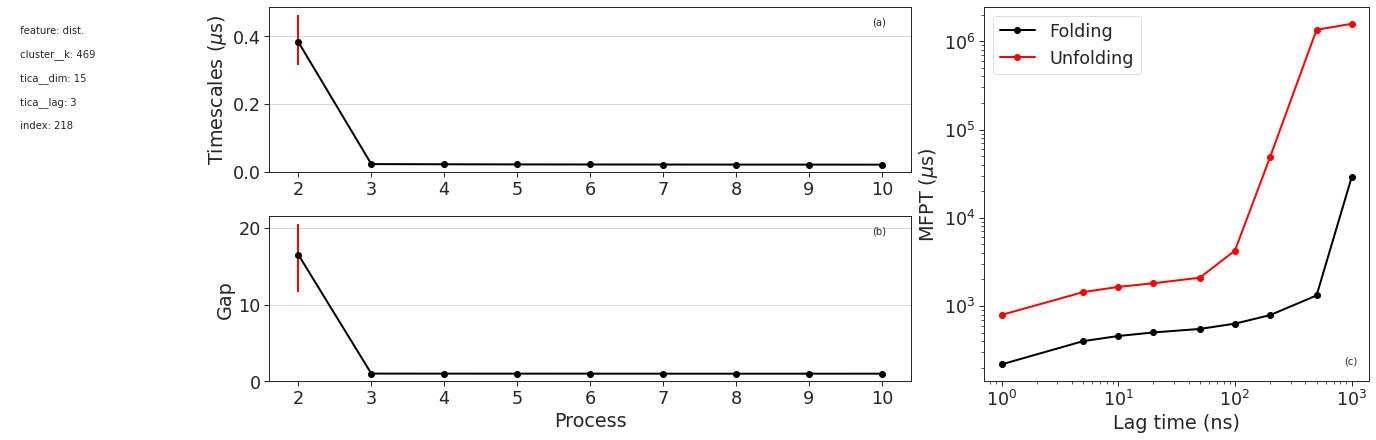

In [12]:
# Figure 2 : HP table + TS + TS gap

with sns.plotting_context('paper', font_scale=2):
    fig = plt.figure(figsize=(19, 6), constrained_layout=True)
    gs = fig.add_gridspec(nrows=6, ncols=19)
    
    # Hyperparameter values
    ax1 = fig.add_subplot(gs[:, :3])
    ax1.text(0.05, 0.95, str_to_print, transform=ax1.transAxes, verticalalignment='top')

    ax1.axis('off')
    
    # Timescales
    ax2 = fig.add_subplot(gs[:3, 3:13])
    x = np.arange(n_ts-1)+2
    y = ts_median
    yerr = (ts_median-ts_lb, ts_ub-ts_median)
    ax2.errorbar(x, y, yerr, elinewidth=2, lw=2, marker='o', markersize=6, ecolor='r', c='k')
    
    ax2.set_ylabel(r"Timescales ($\mu$s)")
    ax2.tick_params(bottom=True, top=False, left=True, right=False)
    ax2.annotate(text='(a)', xy=(0.94, 0.94), xycoords='axes fraction', ha='left', va='top')
    ax2.grid(visible=True, axis='y')
    ax2.set_ylim([0, max(ts_ub)*1.05])
    
    # Gaps
    ax3 = fig.add_subplot(gs[3:, 3:13])
    y = gap_median
    yerr = (gap_median-gap_lb, gap_ub-gap_median)
    ax3.errorbar(x, y, yerr, elinewidth=2, lw=2, marker='o', markersize=6, ecolor='r', c='k')
    
    ax3.set_ylabel("Gap")
    ax3.set_xlabel('Process')
    ax3.tick_params(bottom=True, top=False, left=True, right=False)
    ax3.annotate(text='(b)', xy=(0.94, 0.94), xycoords='axes fraction', ha='left', va='top')
    ax3.grid(visible=True, axis='y')
    ax3.set_ylim([0, max(gap_ub)*1.05])
    
    
    # MFPTs vs lags
    ax4 = fig.add_subplot(gs[0:, 13:])
    ax4.loglog(lags_test, mfpts_fold, marker='o', lw=2, markersize=6, c='k', label='Folding')
    ax4.loglog(lags_test, mfpts_unfold, marker='o', lw=2, markersize=6, c='r', label='Unfolding')

    ax4.tick_params(which='both', axis='both', bottom=True, top=False, left=True, right=False)
    ax4.set_ylabel("MFPT ($\mu$s)")
    ax4.set_xlabel("Lag time (ns)")
    ax4.legend(loc='upper left')
    ax4.annotate(text='(c)', xy=(0.97, 0.04), xycoords='axes fraction', ha='right', va='bottom')
    
    plt.savefig(fig_dir.joinpath('SI_fig2.png'), bbox_inches='tight')
    plt.show()

---
### Validate single MSM --- Figure 1

In [ ]:
# Validate a single trial

ftrajs = featurizer(hps.loc[hp_ix,:].to_dict(), traj_paths, top_path)
# assert len(ftrajs) == len(ftrajs_all)

ttrajs, tica_mod = tica(hps.loc[hp_ix, :].to_dict(), ftrajs)
dtrajs, kmeans_mod = kmeans(hps.loc[hp_ix, :].to_dict(), ttrajs, seed)

out_dir = Path.joinpath(base_dir, Path(f'dtrajs'))
out_dir.mkdir(parents=True, exist_ok=True)

for j in range(len(traj_paths)): 
    traj_path = Path(traj_paths[j]).resolve()
    np.save(file=out_dir.joinpath(traj_path.with_suffix('.npy').name), arr=dtrajs[j])
    
msm = pm.msm.estimate_markov_model(dtrajs, lag=lag)
_ = msm.pcca(n_sets)
ts = msm.timescales(n_ts)

In [ ]:
# Compute PCCA population

print('\nstate\tπ\t\tG/kT\t\tNo.')
population = []
number = []
for i, s in enumerate(msm.metastable_sets):
    p = msm.pi[s].sum()
    population.append(p)
    number.append(s.shape[0]) 
    print('{}\t{:f}\t{:f}\t{}'.format(i, p, -np.log(p), s.shape[0]))

In [ ]:
# Compute core set 

ix_ls = []
core_memberships = msm.metastable_memberships.T > core_membership_cutoff
for i in range(len(core_memberships)):
    ix_ls.append(np.where(core_memberships[i])[0])
core_sets = np.array(ix_ls)

# Compute MFPT between core sets

mfpt = np.zeros((n_sets, n_sets))
for i, j in product(range(n_sets), repeat=2):
    mfpt[i, j] = msm.mfpt(core_sets[i], core_sets[j])

mfpt_df = pd.DataFrame(np.round(mfpt, decimals=2), index=range(1, n_sets + 1), columns=range(1, n_sets + 1))
print(mfpt_df, '\n(ns)')

In [ ]:
# Map reference conformation
# Not used

ref_path = [r'../../../chignolin/5AWL_H.pdb']
    # [r'../../../1fme/1fme.pdb' ]
test_labels = '5AWL'
    # '1FME'

ftraj_test = featurizer(hps.loc[hp_ix, :].to_dict(), ref_path, top_path)
ftraj_test_tica = tica_mod.transform(ftraj_test)
microstate = kmeans_mod.assign(ftraj_test_tica)
metastate = msm.metastable_assignments[microstate]
#test_dict = {label:[test_traj_path[i], microstate[i][0], metastate[i][0]] for i, label in enumerate(test_labels)}

In [ ]:
mem = msm.metastable_memberships.transpose()

# Microstate positions
x = kmeans_mod.clustercenters[:, 0]
y = kmeans_mod.clustercenters[:, 1]  

# Concatenate featurised trajectories
Y = np.concatenate(ttrajs)

# Find cluster center
dists = msm.metastable_distributions.copy()
dists[msm.metastable_memberships.T<core_membership_cutoff] = 0
dists = dists/np.sum(dists, axis=1)[:, np.newaxis]
max_dists = dists.copy()
mask = max_dists==np.tile(np.max(max_dists, axis=1)[:, np.newaxis], (max_dists.shape[1]))
max_ix = np.where(mask)[1]

In [ ]:
# Figure 1
pccas = []
pcca_cbs = []
fes_cbs = []

with sns.plotting_context('paper', font_scale=2):
    fig = plt.figure(figsize=(32, 32))
    gs = fig.add_gridspec(nrows=54, ncols=54)
    
    # Axes assignment 
    pccas.extend([fig.add_subplot(gs[:11, :11]), fig.add_subplot(gs[:11, 18:29])])
    mfpt = fig.add_subplot(gs[14:25, :11])   
    ev = fig.add_subplot(gs[14:25, 18:29])
    
    fes_cbs.extend([fig.add_subplot(gs[:11, 11]), fig.add_subplot(gs[:11, 29]),
                    fig.add_subplot(gs[14:25, 11]), fig.add_subplot(gs[14:25, 29])])
    pcca_cbs.extend([fig.add_subplot(gs[:11, 14]), fig.add_subplot(gs[:11, 32])])
    ev_cb = fig.add_subplot(gs[14:25, 32])
    
    if n_sets == 3: 
        pccas.append(fig.add_subplot(gs[:11, 36:47]))
        pcca_cbs.append(fig.add_subplot(gs[:11, 50]))
        fes_cbs.insert(2, fig.add_subplot(gs[:11, 47]))
    
        
    # Plot metastable membership
    for i_set, ax in enumerate(pccas):
        _, _ = pm.plots.plot_free_energy(Y[:, 0], Y[:, 1], cmap='viridis', 
                                    alpha=0.5, 
                                    weights=np.concatenate(msm.trajectory_weights()),
                                    cbar_label='Free Energy / kT', 
                                    ax=ax, cax=fes_cbs[i_set])
        
        # Microstates
        ms = pccas[i_set].scatter(x=x, y=y, c=mem[i_set], cmap='Greys', s=25, 
                       vmin=mem[i_set].min(), vmax=mem[i_set].max())
        cbar = plt.colorbar(ms, cax=pcca_cbs[i_set])
        cbar.ax.set_ylabel('Probability')
        
        # Macrostate centers 
        pccas[i_set].scatter(x=x[max_ix[i_set]],y=y[max_ix[i_set]], color='b', marker='*',
                             s=300, label='Center')
        
        # Macrostate population
        pccas[i_set].annotate(text=f"Population: {population[i_set]:.2f}", xy=(0.98, 0), xycoords='axes fraction', ha='right', va='bottom')
        
    
    # Plot core set assignment & MFPT
    _, _ = pm.plots.plot_free_energy(Y[:, 0], Y[:, 1], cmap='viridis', 
                                alpha=0.5, 
                                weights=np.concatenate(msm.trajectory_weights()),
                                cbar_label='Free Energy / kT', 
                                ax=mfpt, cax=fes_cbs[i_set+1])
    for i_set in range(n_sets):
        ms = mfpt.scatter(x=x[core_sets[i_set]], y=y[core_sets[i_set]], c=['r','b','m'][i_set],
                          label=f'{i_set+1}', s=25)
    
    txt = 'MFPT (ns):\n'    
    if n_sets == 2:
        txt += f'1->2 {mfpt_df.iloc[0,1]}\n2->1 {mfpt_df.iloc[1,0]}'
    else:
        txt += f'1->2 {mfpt_df.iloc[0,1]}; 1->3 {mfpt_df.iloc[0,2]}\n2->1 {mfpt_df.iloc[1,0]}; 2->3 {mfpt_df.iloc[1,2]}\n3->1 {mfpt_df.iloc[2,0]}; 3->2 {mfpt_df.iloc[2,1]} '
    
    
    # Plot 2nd eigenvector 
    _, _ = pm.plots.plot_free_energy(Y[:, 0], Y[:, 1], cmap='viridis', 
                                alpha=0.5, 
                                weights=np.concatenate(msm.trajectory_weights()),
                                cbar_label='Free Energy / kT', 
                                ax=ev, cax=fes_cbs[i_set+2])
    
    vmin = np.min(msm.eigenvectors_right()[:, 1]) 
    vmax = np.max(msm.eigenvectors_right()[:, 1]) 
    divnorm=colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)
    egv_max = msm.eigenvectors_right()[:, 1].argmax()
    egv_min = msm.eigenvectors_right()[:, 1].argmin()
    
    ms = ev.scatter(x=x, y=y, c=msm.eigenvectors_right()[:, 1], cmap='bwr', norm=divnorm, s=25)    
    ev.scatter(x=x[egv_max], y=y[egv_max], c='k', 
                  cmap='bwr', norm=divnorm, marker='X', s=150, alpha=1, label='Max')
    ev.scatter(x=x[egv_min], y=y[egv_min], c='k', 
                  cmap='bwr', norm=divnorm, marker='v', s=150, alpha=1, label='Min')
    cbar = plt.colorbar(ms, cax=ev_cb, ticks=[np.ceil(vmin*10)/10, 0, np.floor(vmax*10)/10])
    cbar.ax.set_yticklabels([np.ceil(vmin*10)/10, 0.0, np.floor(vmax*10)/10])
    cbar.ax.set_ylabel('Eigenvector')
    
    # Configurations
    for i_set, ax in enumerate(pccas):
        ax.tick_params(bottom=True, top=False, left=True, right=False)
        ax.grid(visible=True, axis='both')
        ax.legend(loc='upper left')
        ax.set_xlabel('IC 1')
        ax.set_title(f'Macrostate {i_set+1}', fontsize=24)
    pccas[0].set_ylabel('IC 2')
    for ax in fes_cbs:
        ax.tick_params(bottom=False, top=False, left=False, right=True)
    for ax in pcca_cbs:
        ax.tick_params(bottom=False, top=False, left=False, right=True)
        
    mfpt.set_xlabel('IC 1')
    mfpt.set_ylabel('IC 2')
    mfpt.legend(loc='upper left')
    mfpt.annotate(text=txt, xy=(0.98, 0), xycoords='axes fraction', ha='right', va='bottom')
    mfpt.grid(visible=True, axis='both')
    mfpt.tick_params(bottom=True, top=False, left=True, right=False)
    mfpt.set_title('Core sets', fontsize=24)
    
    ev.legend(loc='upper left')
    ev.grid(visible=True, axis='both')
    ev.set_xlabel('IC 1')
    ev.set_ylabel('IC 2')
    ev.tick_params(bottom=True, top=False, left=True, right=False)
    ev.set_title('$2^{nd}$ eigenvector', fontsize=24)
    
    for i, ax in enumerate(pccas+[mfpt, ev]):
        ax.annotate(text=f'({string.ascii_lowercase[i]})', xy=(0.89, 0.95), xycoords='axes fraction', ha='left', va='top')
        
    
    plt.savefig(fig_dir.joinpath('SI_fig1.png'))
    plt.show()

---
### Sample egv2 extreme states

In [ ]:
is_single_core = True
ref = md.load(ref_path)
state_out_dir = base_dir.joinpath('states')
state_out_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
samples = {}
for i in range(2):
    egv_max = msm.eigenvectors_right()[:, i+1].argmax()
    egv_min = msm.eigenvectors_right()[:, i+1].argmin()
    egv_zero = abs(msm.eigenvectors_right()[:, i+1]).argmin()
    samples[f'egv{i+2}_max_{egv_max}'] = msm.sample_by_state(100, [egv_max])
    samples[f'egv{i+2}_min_{egv_min}'] = msm.sample_by_state(100, [egv_min])
    samples[f'egv{i+2}_zero_{egv_zero}'] = msm.sample_by_state(100, [egv_zero])

In [ ]:
rmsds = []
states = []

with open(state_out_dir.joinpath('out.txt'), 'w') as f: 
    f.writelines(f'Protein {protein}; hp_id {hp_ix}\n')
    
    for n, sample in samples.items():
        outfile = str(state_out_dir.joinpath(f'{n}.pdb'))

        traj = pm.coordinates.save_traj(traj_paths, sample, outfile=None, top=top_path)
        traj.superpose(reference=ref)
        states.append(traj)
        traj.save_pdb(str(outfile))

        # Compute rg
        rg = md.compute_rg(traj)
        ave_rg, std_rg = np.mean(rg), np.std(rg)

        # Compute rmsd (angstrom) within samples
        rmsd_list = []
        for i in range(len(traj)):
            rmsd_list.append(md.rmsd(traj, traj[i]))
        rmsd_array = np.array(rmsd_list)*10
        ave_rmsd, std_rmsd = np.mean(rmsd_array), np.std(rmsd_array)
        
        rmsd = md.rmsd(target=traj, reference=ref)*10
        ave_ref_rmsd, std_ref_rmsd = np.mean(rmsd), np.std(rmsd)
        rmsds.append(rmsd)
        
        f.writelines(f'{n}\naverage_rg {ave_rg:.2f}, std_rg {std_rg:.2f}\naverage_rmsd {ave_rmsd:.2f}, std_rmsd {std_rmsd:.2f}\nave_ref_rmsd {ave_ref_rmsd:.2f}, std_ref_rmsd {std_ref_rmsd:.2f}\n\n')
    
rmsds_df = pd.DataFrame({f"state_{i}": np.round(rmsd,2) for i, rmsd in enumerate(rmsds)}).melt()